In [1]:
%load_ext autoreload
%autoreload 2

import json
import csv
import psycopg2
import os

import numpy as np
import pandas as pd
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
# Regional definitions
regions = ['Pacific', 'East South Central', 'West South Central', 'Mountain',
       'New England', 'South Atlantic', 'West North Central',
       'East North Central', 'Mid-Atlantic']

regions_dict = {"CT": "New England", "MA": "New England",
                "ME": "New England", "NH": "New England",
                "RI": "New England", "VT": "New England", "NJ": "Mid-Atlantic",
                "NY": "Mid-Atlantic", "PA": "Mid-Atlantic",
                "IL": "East North Central", "IN": "East North Central",
                "MI": "East North Central", "OH": "East North Central",
                "WI": "East North Central", "IA": "West North Central",
                "KS": "West North Central", "MN": "West North Central",
                "MO": "West North Central", "NE": "West North Central",
                "ND": "West North Central", "SD": "West North Central",
                "DE": "South Atlantic", "FL": "South Atlantic",
                "GA": "South Atlantic", "MD": "South Atlantic",
                "NC": "South Atlantic", "SC": "South Atlantic",
                "VA": "South Atlantic", "DC": "South Atlantic",
                "WV": "South Atlantic", "AL": "East South Central",
                "KY": "East South Central", "MS": "East South Central",
                "TN": "East South Central","AR": "West South Central",
                "LA": "West South Central", "OK": "West South Central",
                "TX": "West South Central", "AZ": "Mountain",
                "CO": "Mountain", "ID": "Mountain", "MT": "Mountain",
                "NV": "Mountain", "NM": "Mountain", "UT": "Mountain",
                "WY": "Mountain","AK": "Pacific", "CA": "Pacific",
                "HI": "Pacific", "OR": "Pacific", "WA": "Pacific"}

no_data_states = ['AK', 'AR', 'ND', 'SD']

In [3]:
# Connect to server
conn = psycopg2.connect()

In [4]:
# Pull 2016 data
sql = """
SELECT geo_id, state, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE year = 2016;
"""

with conn.cursor() as cur:
    cur.execute(sql)
    output_2016 = cur.fetchall()

In [5]:
# Pull and process data
labels = ['geo_id', 'state', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
df16 = pd.DataFrame.from_records(output_2016, columns = labels)
df16 = df16[~df16['state'].isin(no_data_states)]
df16['region'] = df16['state'].map(regions_dict.get)
# temporally legit?
df16['evictions_per_1k_filings'] = df16['evictions']/df16['eviction_filings']*1000

In [6]:
df16.head()

,geo_id,state,population,eviction_filings,evictions,filing_rate,eviction_rate,region,evictions_per_1k_filings
534,010439642003,AL,692.0,8.0,3.0,9.09,3.41,East South Central,375.000000
535,010010201001,AL,649.0,0.0,0.0,0.00,0.00,East South Central,NaN
536,010010201002,AL,1299.0,1.0,1.0,1.28,1.28,East South Central,1000.000000
537,010010202001,AL,1074.0,3.0,1.0,2.59,0.86,East South Central,333.333333
538,010010202002,AL,1082.0,4.0,1.0,2.55,0.64,East South Central,250.000000


In [7]:
df16.describe()

,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,213832.000000,179825.000000,179825.000000,179825.000000,179825.000000,141236.000000
mean,1455.622208,13.028745,4.995573,5.976922,2.402129,537.298631
std,906.145596,43.528277,10.782919,58.807906,24.125610,359.654048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,892.000000,1.000000,0.000000,0.540000,0.000000,250.000000
50%,1260.000000,3.000000,1.000000,2.460000,1.040000,500.000000
75%,1791.000000,11.000000,5.000000,6.170000,2.970000,937.500000
max,39961.000000,4282.000000,397.000000,14133.330000,9100.000000,1000.000000


In [8]:
# high population outliers
high_pop = df16[df16['population']>20000]
high_pop

,geo_id,state,population,eviction_filings,evictions,filing_rate,eviction_rate,region,evictions_per_1k_filings
27789,060730187001,CA,39454.0,1.0,1.0,0.02,0.02,Pacific,1000.000000
48342,120950167301,FL,30258.0,113.0,46.0,4.01,1.63,South Atlantic,407.079646
51658,121199112001,FL,38169.0,6.0,6.0,0.97,0.97,South Atlantic,1000.000000
184768,480396606022,TX,22054.0,2.0,0.0,0.10,0.00,West South Central,0.000000
189312,481576729001,TX,38137.0,134.0,66.0,5.17,2.54,West South Central,492.537313
189320,481576731011,TX,39961.0,72.0,41.0,3.02,1.72,West South Central,569.444444


First is a San Diego county, 2nd Orange County, 3rd Sumpter,  

## Population vs Eviction Filings, Evictions

The large number of observations on all of these plots makes them a bit difficult to parse, but the overall goal is to see to what extent the number of eviction filings and eviction filings are linearly increasing in population. The first view is overall nationally, the second is by each geographic region to show regional variation.

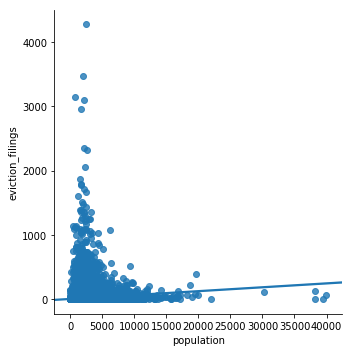

In [9]:
# Pop vs eviction filings, 2016
sns.lmplot(x = 'population', y = 'eviction_filings', data = df16)

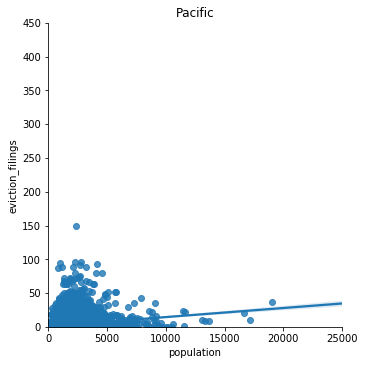

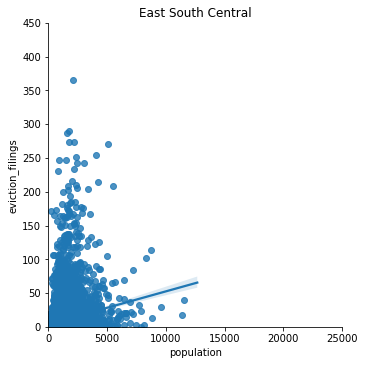

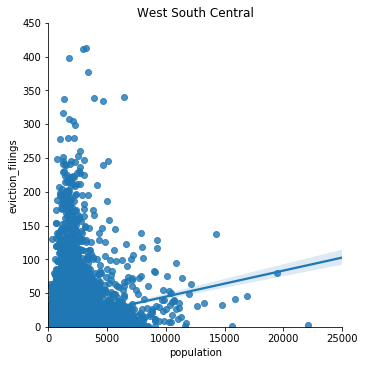

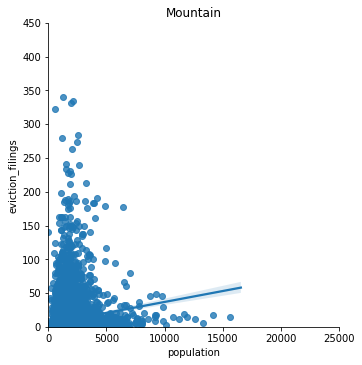

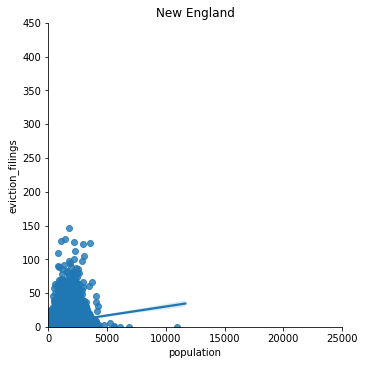

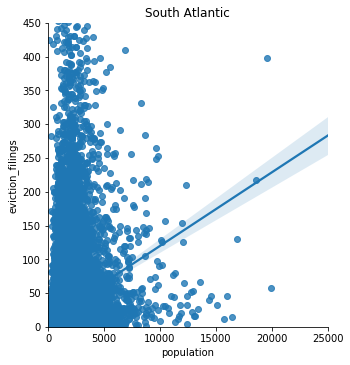

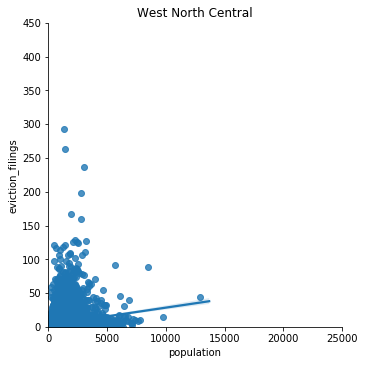

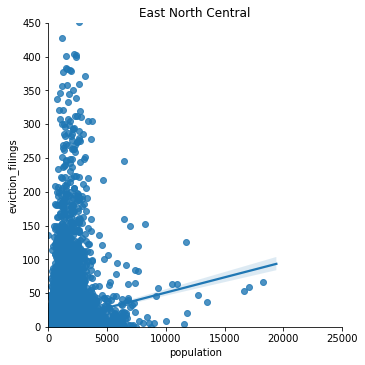

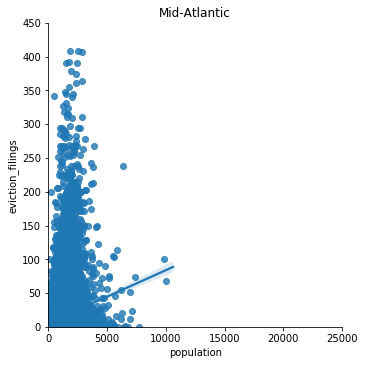

In [36]:
for region in regions:
    regdf = df16[df16['region']==region]
    sns.lmplot(x = 'population', y = 'eviction_filings', data = regdf)
    plt.title(region)
    plt.xlim(0,25000)
    plt.ylim(0,450)

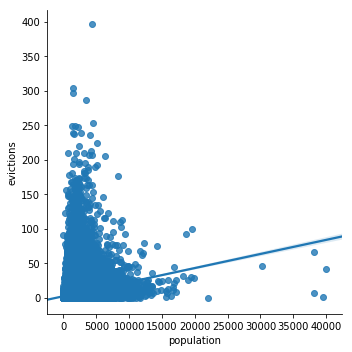

In [11]:
# Pop vs evictions, 2016
sns.lmplot(x = 'population', y = 'evictions', data = df16)

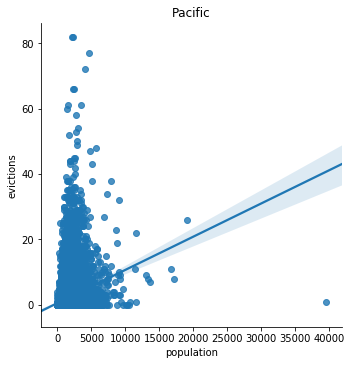

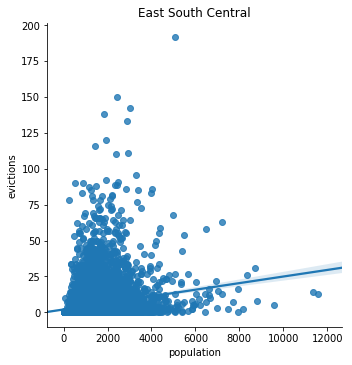

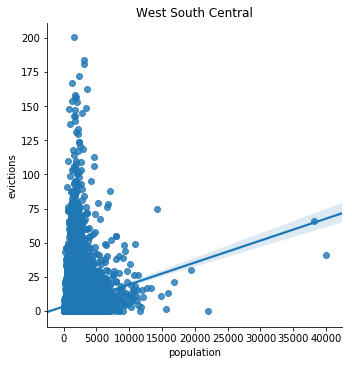

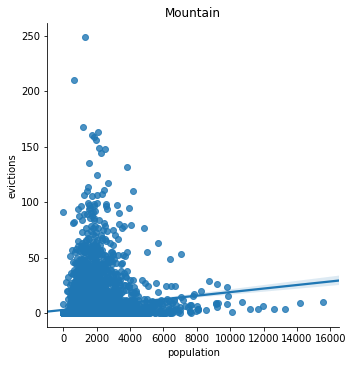

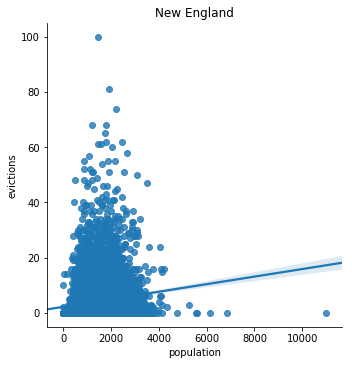

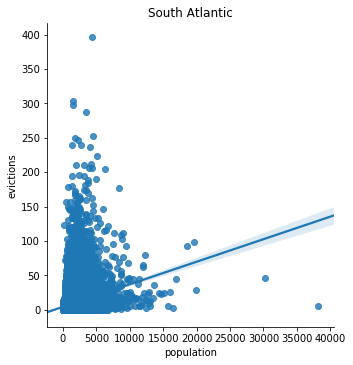

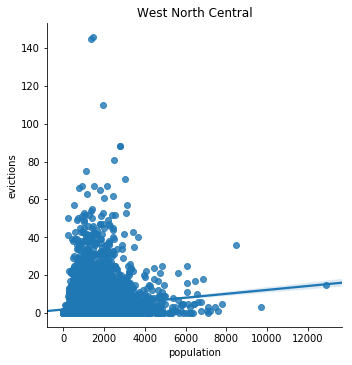

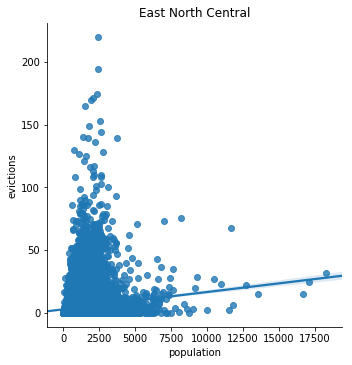

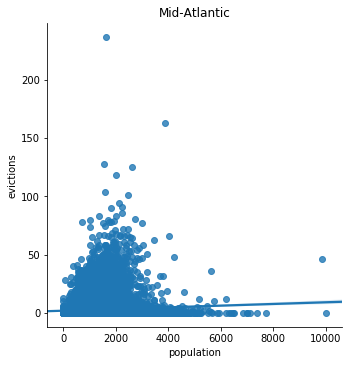

In [12]:
for region in regions:
    regdf = df16[df16['region']==region]
    sns.lmplot(x = 'population', y = 'evictions', data = regdf)
    plt.title(region)

## Eviction Filings vs Evictions

Overall and by region, to what extent do eviction filings translate into more actual evictions?

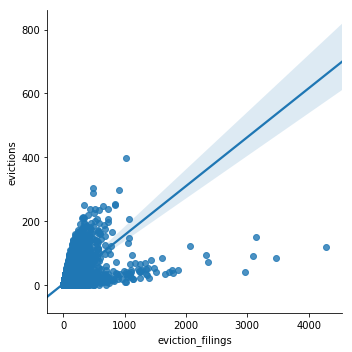

In [13]:
sns.lmplot(x = 'eviction_filings', y = 'evictions', data = df16)

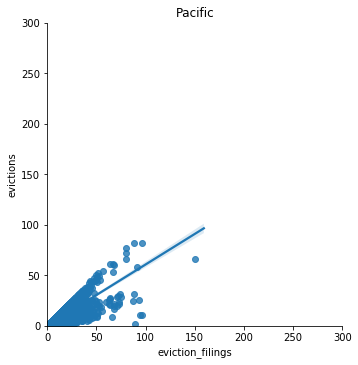

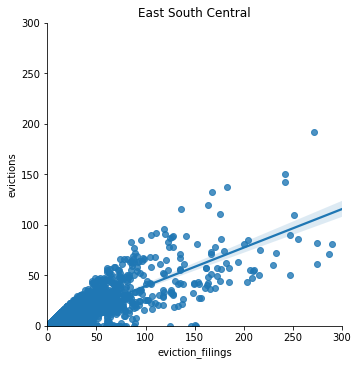

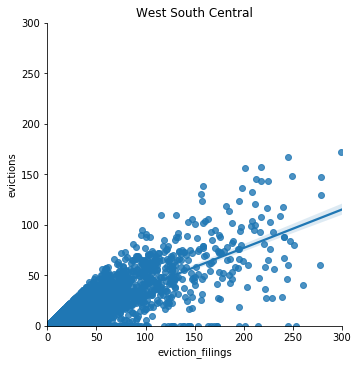

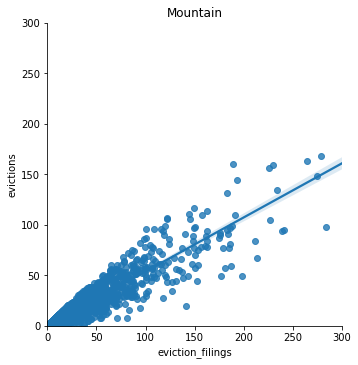

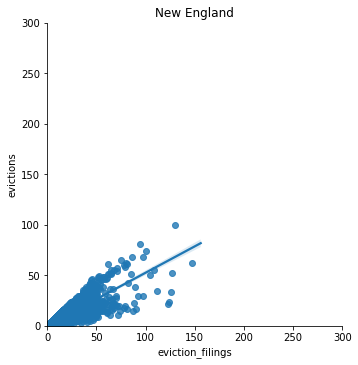

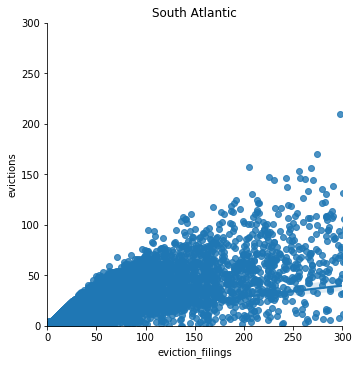

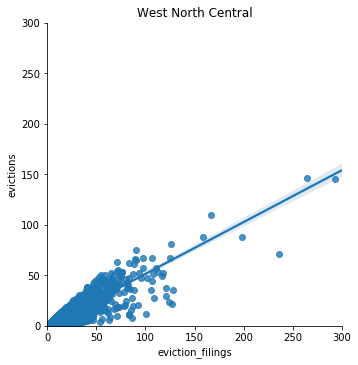

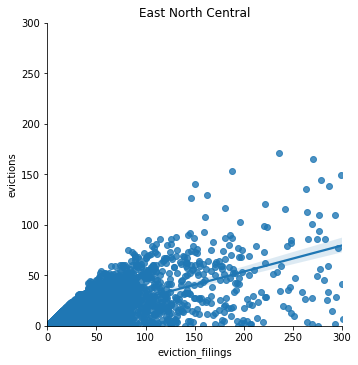

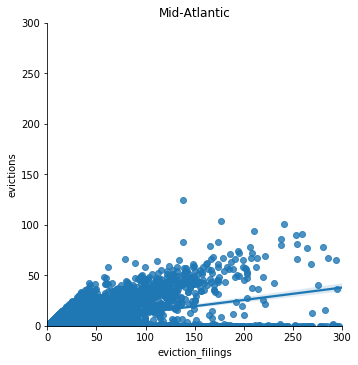

In [35]:
for region in regions:
    regdf = df16[df16['region']==region]
    sns.lmplot(x = 'eviction_filings', y = 'evictions', data = regdf)
    plt.title(region)
    plt.xlim(0, 300) 
    plt.ylim(0,300)

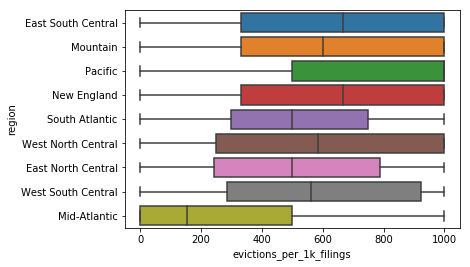

In [15]:
sns.boxplot(x = 'evictions_per_1k_filings', y='region', data = df16)

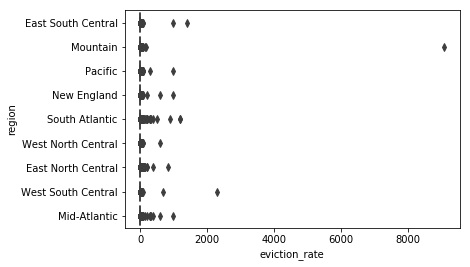

In [16]:
# crazy outliers, need to exclude those outside of a reasonable bound
sns.boxplot(x = 'eviction_rate', y='region', data = df16)

In [40]:
# What's up in the Midatlantic? Real or not? Have these cases not closed? check other years?
midatl = df16[df16['region']=='Mid-Atlantic']
midatl.describe()

,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,31523.000000,23054.000000,23054.000000,23054.000000,23054.000000,17525.000000
mean,1311.967325,15.711894,2.925479,6.909052,1.386768,295.990396
std,664.981461,33.845754,7.554564,34.762746,9.626004,350.995429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,865.000000,1.000000,0.000000,0.360000,0.000000,0.000000
50%,1187.000000,4.000000,0.000000,3.080000,0.000000,153.846154
75%,1615.000000,15.000000,2.000000,7.850000,1.480000,500.000000
max,10003.000000,700.000000,237.000000,2900.000000,1000.000000,1000.000000


## Population vs Filing Rates, Eviction Rates

This view doesn't seem very useful; data points are too compacted for this visualization. Why are so many of the rates >1?

In [26]:
# remove high rate outliers, <=10
low_rates = df16[df16['filing_rate']<=10]

(0, 10000)

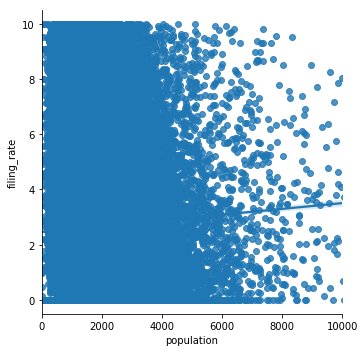

In [27]:
sns.lmplot(x = 'population', y = 'filing_rate', data = low_rates)
plt.xlim(0,10000)

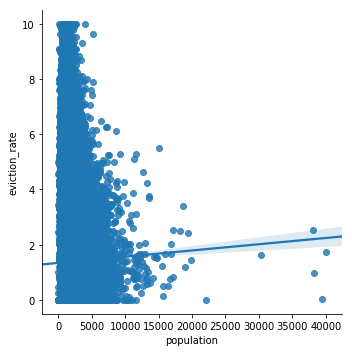

In [28]:
sns.lmplot(x = 'population', y = 'eviction_rate', data = low_rates)

## Top 20%

In [ ]:
# Number that constitutes the top 20% of blockgroups
num = df16.shape[0]
n_lrg = int(num*0.2)

In [44]:
# determine the top 20% by number of evictions
top_20pct_num = df16.nlargest(n_lrg, columns='evictions')
#top_20pct_num

In [45]:
# Distribution of top 20% of num evictions by state
top20_num = top_20pct_num.groupby('state')['geo_id'].count().to_frame()

In [46]:
# Top 20% by eviction rate
top_20pct_rate = df16.nlargest(n_lrg, columns='eviction_rate')
#top_20pct_rate

In [32]:
# Distribution of top 20% by eviction rate
top20_rate = top_20pct_rate.groupby('state')['geo_id'].count().to_frame()

In [38]:
# comparison # of blockgroups in top 20% by eviction num, eviction rate
top20_comp = pd.merge(top20_num, top20_rate, left_index=True, right_index=True, how='left')
col_map = {'geo_id_x':'num', 'geo_id_y':'rate'}
top20_comp.rename(col_map, axis = 1, inplace = True)
top20_comp

,num,rate
state,,
AL,642,519
AZ,325,282
CA,2055,1159
CO,768,632
CT,690,802
DC,191,134
DE,261,310
FL,3567,2867
GA,2326,2269


Text(0.5,1,'Number of Block Groups included in Top 20 Designation by State')

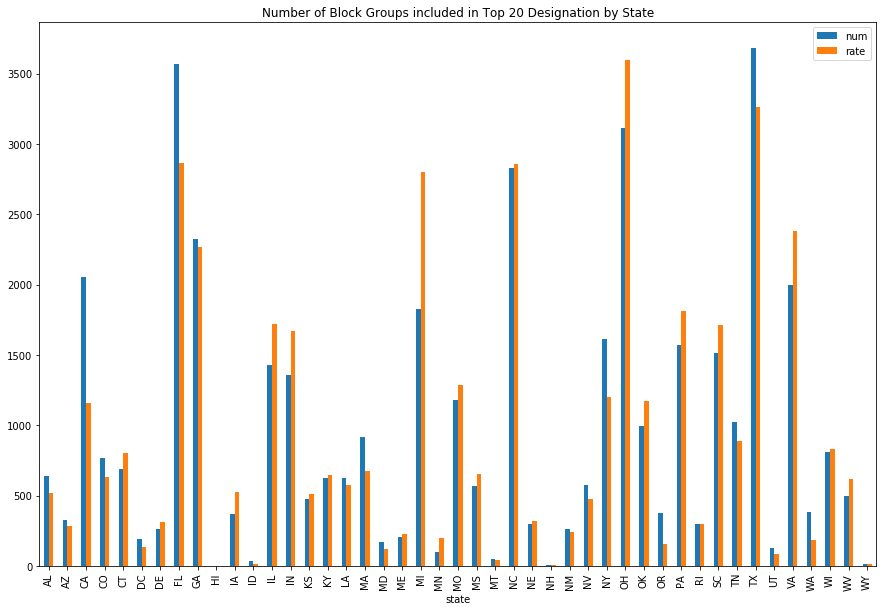

In [42]:
top20_comp.plot(kind='bar', figsize = (15,10))
plt.title('Number of Block Groups included in Top 20 Designation by State')

## Find a specific block or two that changed significantly over the time period

## Regional Looks over Time

### Midatlantic Look

The eviction pattern seems significantly different in the Mid-Atlantic (NY, NJ, PA) than elsewhere. Closer view over time. Is the huge drop in ~2007 in NY a data issue or caused by legislative change, etc.?

In [18]:
sql_ma = """
SELECT geo_id, state, year, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE state = 'NJ' 
OR state = 'NY' 
OR state = 'PA';
"""

with conn.cursor() as cur:
    cur.execute(sql_ma)
    output_ma = cur.fetchall()

In [19]:
ma_labels = ['geo_id', 'state', 'year', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
dfma = pd.DataFrame.from_records(output_ma, columns = ma_labels)
dfma['evictions_per_1k_filings'] = dfma['evictions']/dfma['eviction_filings']*1000

In [20]:
dfma.head()

,geo_id,state,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
0,340010012001,NJ,2000,952.0,NaN,NaN,NaN,NaN,NaN
1,340010103002,NJ,2000,1272.0,NaN,NaN,NaN,NaN,NaN
2,340010130001,NJ,2000,1581.0,NaN,NaN,NaN,NaN,NaN
3,340030031001,NJ,2000,829.0,NaN,NaN,NaN,NaN,NaN
4,340030151002,NJ,2000,636.0,NaN,NaN,NaN,NaN,NaN


In [21]:
dfma.describe()

,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,535902.000000,535902.000000,368392.000000,368392.000000,368392.000000,368392.000000,295219.000000
mean,2007.999938,1287.990449,18.640522,3.751379,8.282285,2.036147,355.810622
std,4.898974,614.346162,44.342265,7.235744,119.757387,22.081402,352.880046
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,871.920000,1.000000,0.000000,1.100000,0.000000,0.000000
50%,2008.000000,1175.000000,5.000000,1.000000,4.120000,0.740000,250.000000
75%,2012.000000,1580.000000,17.000000,4.000000,9.320000,2.620000,607.142857
max,2016.000000,12780.000000,1921.000000,299.000000,50000.000000,11111.110000,1000.000000


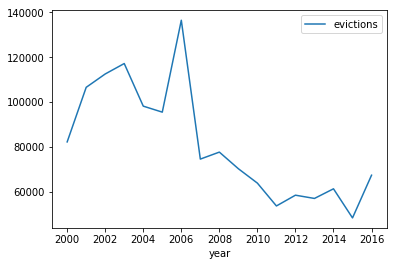

In [22]:
dfma.groupby('year')['evictions'].sum().to_frame().plot(kind='line')

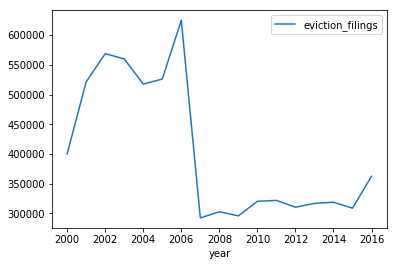

In [23]:
dfma.groupby('year')['eviction_filings'].sum().to_frame().plot(kind='line')

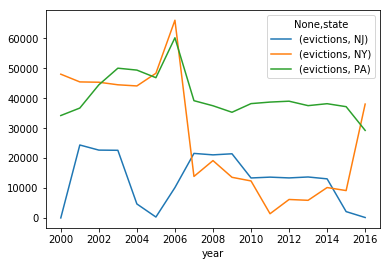

In [24]:
# total over time, evictions
dfma.groupby(['state','year'])['evictions'].sum().to_frame().unstack(level=0).plot(kind='line')

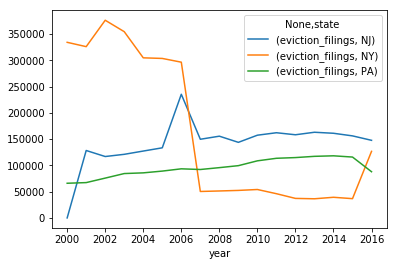

In [25]:
dfma.groupby(['state','year'])['eviction_filings'].sum().to_frame().unstack(level=0).plot(kind='line')

### Pacific

In [51]:
df16[df16['region']=='Pacific']['state'].unique()

array(['CA', 'HI', 'OR', 'WA'], dtype=object)

In [52]:
sql_pac = """
SELECT geo_id, state, year, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE state = 'CA' 
OR state = 'HI' 
OR state = 'OR'
OR state = 'WA';
"""

with conn.cursor() as cur:
    cur.execute(sql_pac)
    output_pac = cur.fetchall()

In [53]:
reg_labels = ['geo_id', 'state', 'year', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
dfpac = pd.DataFrame.from_records(output_pac, columns = reg_labels)
dfpac['evictions_per_1k_filings'] = dfpac['evictions']/dfpac['eviction_filings']*1000

In [54]:
dfpac.describe()

,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,535568.000000,535568.000000,444472.000000,444472.000000,444472.000000,444472.000000,334990.000000
mean,2008.000000,1520.685314,4.832928,3.651355,2.235445,1.685085,774.386981
std,4.898984,860.565743,7.917828,6.063891,6.081602,5.238453,317.307251
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,982.000000,1.000000,0.000000,0.160000,0.000000,600.000000
50%,2008.000000,1357.160000,2.000000,2.000000,1.370000,0.980000,1000.000000
75%,2012.000000,1880.000000,6.000000,4.000000,3.002500,2.300000,1000.000000
max,2016.000000,39454.000000,218.000000,207.000000,1374.570000,1374.570000,1000.000000


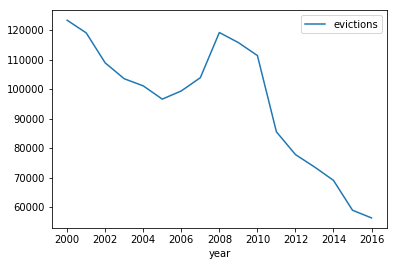

In [55]:
dfpac.groupby('year')['evictions'].sum().to_frame().plot(kind='line')

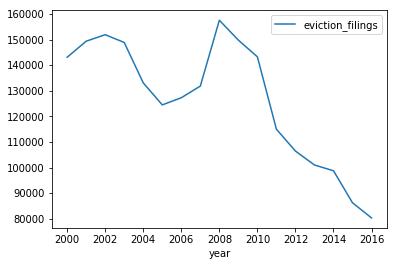

In [56]:
dfpac.groupby('year')['eviction_filings'].sum().to_frame().plot(kind='line')

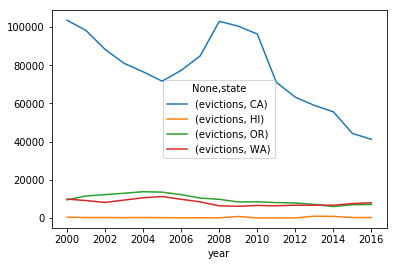

In [57]:
# total over time, evictions
dfpac.groupby(['state','year'])['evictions'].sum().to_frame().unstack(level=0).plot(kind='line')

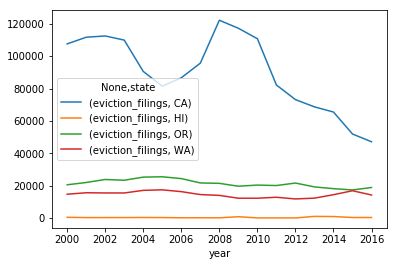

In [58]:
dfpac.groupby(['state','year'])['eviction_filings'].sum().to_frame().unstack(level=0).plot(kind='line')

### East South Central

In [59]:
df16[df16['region']=='East South Central']['state'].unique()

array(['AL', 'KY', 'MS', 'TN'], dtype=object)

In [65]:
sql_esc = """
SELECT geo_id, state, year, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE state = 'AL' 
OR state = 'KY' 
OR state = 'MS'
OR state = 'TN';
"""

with conn.cursor() as cur:
    cur.execute(sql_esc)
    output_esc = cur.fetchall()

In [66]:
reg_labels = ['geo_id', 'state', 'year', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
dfesc = pd.DataFrame.from_records(output_esc, columns = reg_labels)
dfesc['evictions_per_1k_filings'] = dfesc['evictions']/dfesc['eviction_filings']*1000

In [67]:
dfesc.describe()

,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,221134.000000,221134.000000,182612.000000,182612.000000,182612.000000,182612.000000,141236.000000
mean,2008.000317,1381.814016,9.765530,5.129712,4.836638,2.642693,665.661240
std,4.899669,690.618125,23.110314,10.223473,25.243535,15.959033,347.813793
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,915.000000,1.000000,0.000000,0.630000,0.000000,400.000000
50%,2008.000000,1252.000000,3.000000,2.000000,2.340000,1.480000,750.000000
75%,2012.000000,1699.000000,9.000000,5.000000,5.390000,3.450000,1000.000000
max,2016.000000,12069.000000,629.000000,259.000000,5555.560000,5555.560000,1000.000000


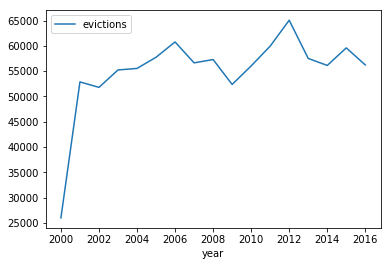

In [68]:
dfesc.groupby('year')['evictions'].sum().to_frame().plot(kind='line')

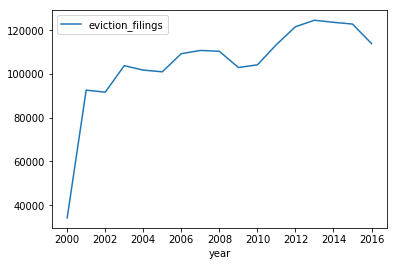

In [69]:
dfesc.groupby('year')['eviction_filings'].sum().to_frame().plot(kind='line')

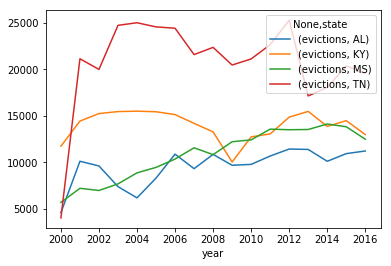

In [70]:
# total over time, evictions
dfesc.groupby(['state','year'])['evictions'].sum().to_frame().unstack(level=0).plot(kind='line')

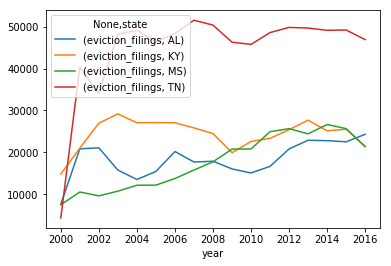

In [71]:
dfesc.groupby(['state','year'])['eviction_filings'].sum().to_frame().unstack(level=0).plot(kind='line')

### West South Central

In [72]:
df16[df16['region']=='West South Central']['state'].unique()

array(['LA', 'OK', 'TX'], dtype=object)

In [73]:
sql_wsc = """
SELECT geo_id, state, year, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE state = 'LA' 
OR state = 'OK' 
OR state = 'TX';
"""

with conn.cursor() as cur:
    cur.execute(sql_wsc)
    output_wsc = cur.fetchall()

In [74]:
reg_labels = ['geo_id', 'state', 'year', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
dfwsc = pd.DataFrame.from_records(output_wsc, columns = reg_labels)
dfwsc['evictions_per_1k_filings'] = dfwsc['evictions']/dfwsc['eviction_filings']*1000

In [75]:
dfwsc.describe()

,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,378054.000000,378054.000000,318946.000000,318946.000000,318946.000000,318946.000000,249607.000000
mean,2008.000384,1445.194950,11.719501,5.728951,5.860343,3.013031,629.053730
std,4.899808,917.717453,26.655462,11.468795,53.195517,27.164703,340.632154
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,892.000000,1.000000,0.000000,0.620000,0.000000,375.000000
50%,2008.000000,1252.000000,4.000000,2.000000,2.780000,1.580000,666.666667
75%,2012.000000,1774.000000,11.000000,6.000000,6.690000,3.890000,1000.000000
max,2016.000000,39961.000000,720.000000,275.000000,22000.000000,11000.000000,1000.000000


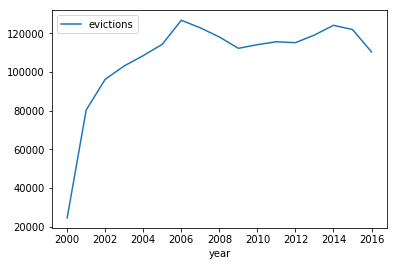

In [76]:
dfwsc.groupby('year')['evictions'].sum().to_frame().plot(kind='line')

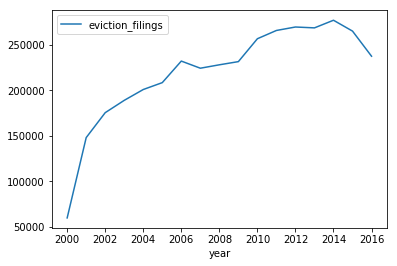

In [77]:
dfwsc.groupby('year')['eviction_filings'].sum().to_frame().plot(kind='line')

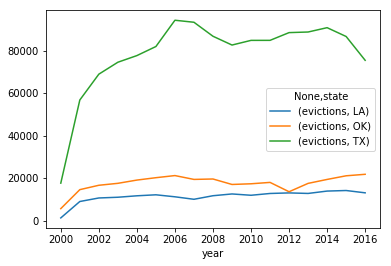

In [78]:
# total over time, evictions
dfwsc.groupby(['state','year'])['evictions'].sum().to_frame().unstack(level=0).plot(kind='line')

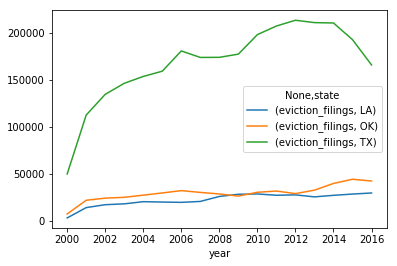

In [79]:
dfwsc.groupby(['state','year'])['eviction_filings'].sum().to_frame().unstack(level=0).plot(kind='line')

### Mountain

In [82]:
df16[df16['region']=='Mountain']['state'].unique()

array(['AZ', 'CO', 'ID', 'MT', 'NM', 'NV', 'UT', 'WY'], dtype=object)

In [83]:
sql_mtn = """
SELECT geo_id, state, year, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE state = 'AZ' 
OR state = 'CO' 
OR state = 'ID'
OR state = 'MT'
OR state = 'NM'
OR state = 'NV'
OR state = 'UT'
OR state = 'WY';
"""

with conn.cursor() as cur:
    cur.execute(sql_mtn)
    output_mtn = cur.fetchall()

In [84]:
reg_labels = ['geo_id', 'state', 'year', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
dfmtn = pd.DataFrame.from_records(output_mtn, columns = reg_labels)
dfmtn['evictions_per_1k_filings'] = dfmtn['evictions']/dfmtn['eviction_filings']*1000

In [85]:
dfmtn.describe()

,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,253190.000000,253190.00000,169578.000000,169578.000000,169578.000000,169578.000000,126075.000000
mean,2008.000434,1408.47191,11.559701,6.980375,5.558587,3.404101,663.629159
std,4.899920,853.74221,27.507206,15.925536,56.959696,34.525503,331.315833
min,2000.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,905.00000,0.000000,0.000000,0.000000,0.000000,463.414634
50%,2008.000000,1267.00000,3.000000,2.000000,2.410000,1.460000,714.285714
75%,2012.000000,1731.00000,9.000000,6.000000,6.300000,4.140000,1000.000000
max,2016.000000,30059.40000,632.000000,360.000000,14000.000000,9100.000000,1000.000000


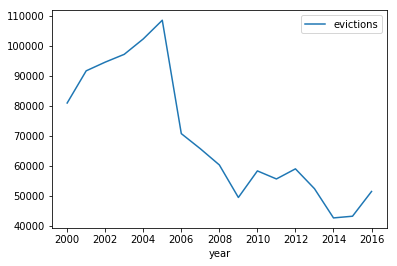

In [86]:
dfmtn.groupby('year')['evictions'].sum().to_frame().plot(kind='line')

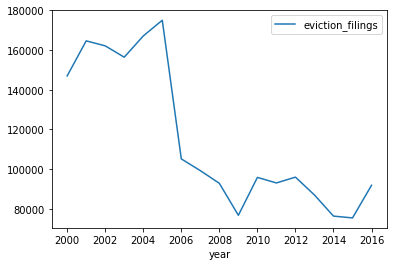

In [87]:
dfmtn.groupby('year')['eviction_filings'].sum().to_frame().plot(kind='line')

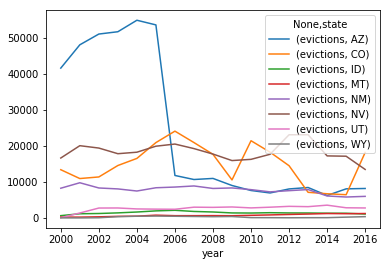

In [88]:
# total over time, evictions
dfmtn.groupby(['state','year'])['evictions'].sum().to_frame().unstack(level=0).plot(kind='line')

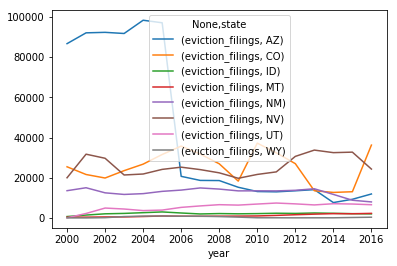

In [89]:
dfmtn.groupby(['state','year'])['eviction_filings'].sum().to_frame().unstack(level=0).plot(kind='line')

### New England

In [91]:
df16[df16['region']=='New England']['state'].unique()

array(['CT', 'MA', 'ME', 'NH', 'RI', 'VT'], dtype=object)

In [92]:
sql_ne = """
SELECT geo_id, state, year, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE state = 'CT' 
OR state = 'MA' 
OR state = 'ME'
OR state = 'NH'
OR state = 'RI'
OR state = 'VT';
"""

with conn.cursor() as cur:
    cur.execute(sql_ne)
    output_ne = cur.fetchall()

In [93]:
reg_labels = ['geo_id', 'state', 'year', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
dfne = pd.DataFrame.from_records(output_ne, columns = reg_labels)
dfne['evictions_per_1k_filings'] = dfne['evictions']/dfne['eviction_filings']*1000

In [94]:
dfne.describe()

,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,185550.000000,185550.000000,124674.000000,124674.000000,124674.000000,124674.000000,88765.000000
mean,2008.000027,1311.754724,5.573095,3.957666,2.835007,2.050312,772.292038
std,4.899050,602.052895,9.975641,6.805288,14.177207,7.552019,299.916576
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,882.000000,0.000000,0.000000,0.000000,0.000000,615.384615
50%,2008.000000,1198.000000,2.000000,1.000000,1.660000,1.190000,928.571429
75%,2012.000000,1627.000000,6.000000,5.000000,3.830000,2.890000,1000.000000
max,2016.000000,10991.000000,260.000000,138.000000,2200.000000,1100.000000,1000.000000


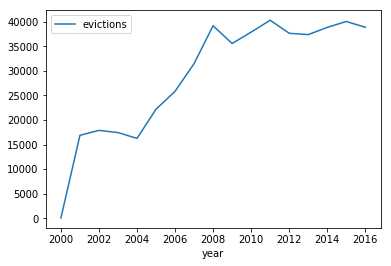

In [95]:
dfne.groupby('year')['evictions'].sum().to_frame().plot(kind='line')

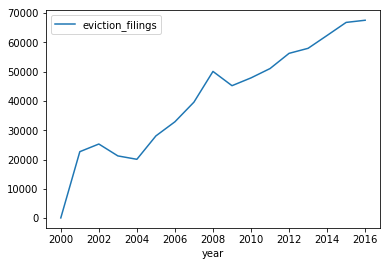

In [96]:
dfne.groupby('year')['eviction_filings'].sum().to_frame().plot(kind='line')

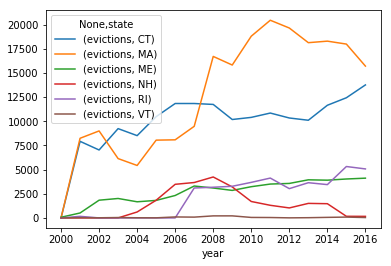

In [97]:
# total over time, evictions
dfne.groupby(['state','year'])['evictions'].sum().to_frame().unstack(level=0).plot(kind='line')

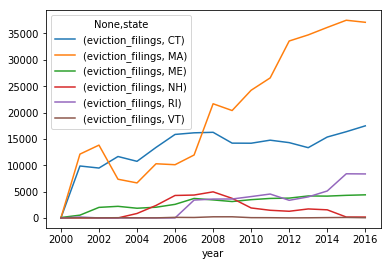

In [98]:
dfne.groupby(['state','year'])['eviction_filings'].sum().to_frame().unstack(level=0).plot(kind='line')

### South Atlantic

In [99]:
df16[df16['region']=='South Atlantic']['state'].unique()

array(['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV'], dtype=object)

In [107]:
sql_sa = """
SELECT geo_id, state, year, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE state = 'DE' 
OR state = 'DC' 
OR state = 'FL'
OR state = 'GA'
OR state = 'MD'
OR state = 'NC'
OR state = 'SC'
OR state = 'VA'
OR state = 'WV';
"""

with conn.cursor() as cur:
    cur.execute(sql_sa)
    output_sa = cur.fetchall()

In [108]:
reg_labels = ['geo_id', 'state', 'year', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
dfsa = pd.DataFrame.from_records(output_sa, columns = reg_labels)
dfsa['evictions_per_1k_filings'] = dfsa['evictions']/dfsa['eviction_filings']*1000

In [109]:
dfsa.describe()

,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,647021.000000,647021.000000,485788.000000,485788.000000,4.857880e+05,485788.000000,423304.000000
mean,2008.000155,1512.767654,24.804174,8.537975,2.322379e+01,6.945530,527.121588
std,4.899094,918.252942,72.160192,16.556245,3.750973e+03,1059.853118,339.947640
min,2000.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2004.000000,932.000000,2.000000,1.000000,1.790000e+00,0.520000,258.047321
50%,2008.000000,1328.000000,6.000000,3.000000,4.930000e+00,2.310000,500.000000
75%,2012.000000,1890.000000,21.000000,9.000000,1.133000e+01,5.130000,850.000000
max,2016.000000,38169.000000,5715.000000,452.000000,2.000000e+06,600000.000000,1000.000000


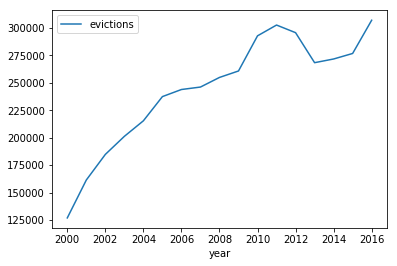

In [110]:
dfsa.groupby('year')['evictions'].sum().to_frame().plot(kind='line')

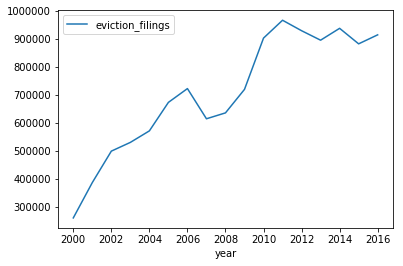

In [111]:
dfsa.groupby('year')['eviction_filings'].sum().to_frame().plot(kind='line')

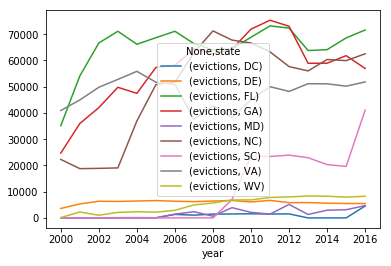

In [112]:
# total over time, evictions
dfsa.groupby(['state','year'])['evictions'].sum().to_frame().unstack(level=0).plot(kind='line')

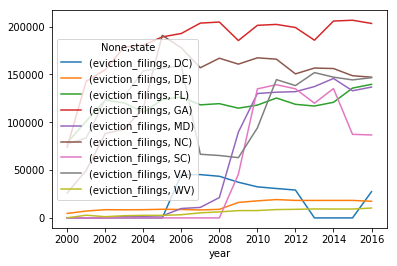

In [113]:
dfsa.groupby(['state','year'])['eviction_filings'].sum().to_frame().unstack(level=0).plot(kind='line')

### West North Central

In [131]:
df16[df16['region']=='West North Central']['state'].unique()

array(['IA', 'KS', 'MN', 'MO', 'NE'], dtype=object)

In [132]:
sql_wnc = """
SELECT geo_id, state, year, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE state = 'IA' 
OR state = 'KS' 
OR state = 'MN'
OR state = 'MO'
OR state = 'NE';
"""

with conn.cursor() as cur:
    cur.execute(sql_wnc)
    output_wnc = cur.fetchall()

In [133]:
reg_labels = ['geo_id', 'state', 'year', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
dfwnc = pd.DataFrame.from_records(output_wnc, columns = reg_labels)
dfwnc['evictions_per_1k_filings'] = dfwnc['evictions']/dfwnc['eviction_filings']*1000

In [134]:
dfwnc.describe()

,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,258222.000000,258222.000000,229039.000000,229039.000000,229039.000000,229039.000000,163539.000000
mean,2008.002730,1225.592462,6.245827,3.748942,4.646532,2.606491,641.050534
std,4.904836,638.871449,11.688195,7.002854,156.190955,49.647507,342.616478
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,809.000000,0.000000,0.000000,0.000000,0.000000,416.666667
50%,2008.000000,1070.000000,2.000000,1.000000,2.140000,1.190000,666.666667
75%,2012.000000,1465.000000,7.000000,4.000000,5.540000,3.400000,1000.000000
max,2016.000000,12899.000000,293.000000,198.000000,66666.670000,16666.670000,1000.000000


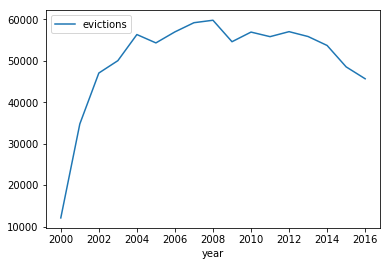

In [135]:
dfwnc.groupby('year')['evictions'].sum().to_frame().plot(kind='line')

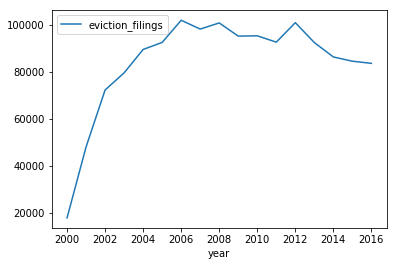

In [136]:
dfwnc.groupby('year')['eviction_filings'].sum().to_frame().plot(kind='line')

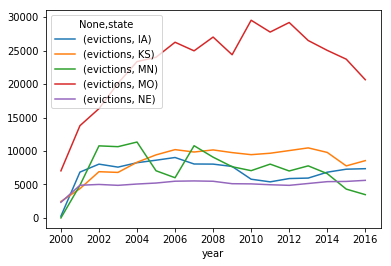

In [137]:
# total over time, evictions
dfwnc.groupby(['state','year'])['evictions'].sum().to_frame().unstack(level=0).plot(kind='line')

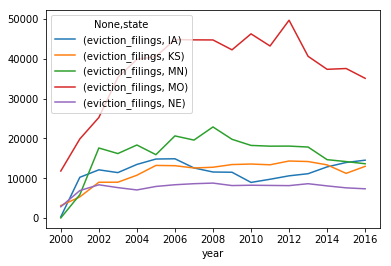

In [138]:
dfwnc.groupby(['state','year'])['eviction_filings'].sum().to_frame().unstack(level=0).plot(kind='line')

### East North Central

In [123]:
df16[df16['region']=='East North Central']['state'].unique()

array(['IL', 'IN', 'MI', 'OH', 'WI'], dtype=object)

In [124]:
sql_enc = """
SELECT geo_id, state, year, population, eviction_filings, evictions, eviction_filing_rate, eviction_rate
FROM blockgroup
WHERE state = 'IL' 
OR state = 'IN' 
OR state = 'MI'
OR state = 'OH'
OR state = 'WI';
"""

with conn.cursor() as cur:
    cur.execute(sql_enc)
    output_enc = cur.fetchall()

In [125]:
reg_labels = ['geo_id', 'state', 'year', 'population', 'eviction_filings', 'evictions', 'filing_rate', 'eviction_rate']
dfenc = pd.DataFrame.from_records(output_enc, columns = reg_labels)
dfenc['evictions_per_1k_filings'] = dfenc['evictions']/dfenc['eviction_filings']*1000

In [126]:
dfenc.describe()

,year,population,eviction_filings,evictions,filing_rate,eviction_rate,evictions_per_1k_filings
count,619389.000000,619389.000000,568375.000000,568375.000000,568375.000000,568375.000000,464657.000000
mean,2008.000065,1264.931335,10.847606,5.287578,6.999838,3.630321,579.750674
std,4.899122,642.585754,24.249711,10.323872,87.556352,74.514066,352.831980
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,841.000000,1.000000,0.000000,1.130000,0.000000,333.333333
50%,2008.000000,1127.000000,4.000000,2.000000,3.470000,1.790000,600.000000
75%,2012.000000,1531.000000,11.000000,6.000000,8.040000,4.570000,1000.000000
max,2016.000000,18272.000000,1194.000000,283.000000,50000.000000,50000.000000,1000.000000


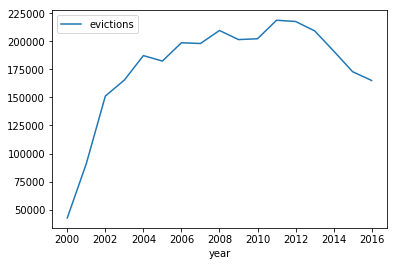

In [127]:
dfenc.groupby('year')['evictions'].sum().to_frame().plot(kind='line')

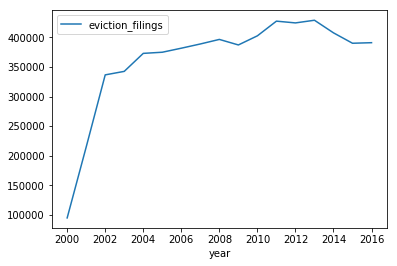

In [128]:
dfenc.groupby('year')['eviction_filings'].sum().to_frame().plot(kind='line')

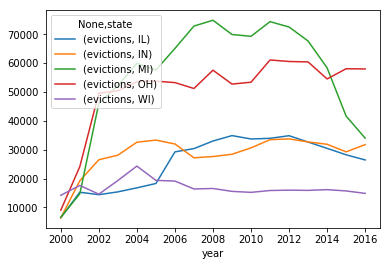

In [129]:
# total over time, evictions
dfenc.groupby(['state','year'])['evictions'].sum().to_frame().unstack(level=0).plot(kind='line')

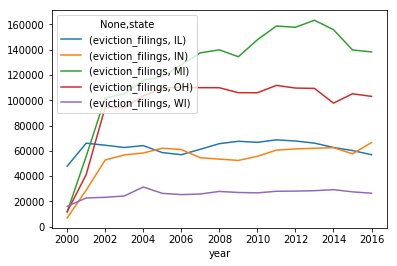

In [130]:
dfenc.groupby(['state','year'])['eviction_filings'].sum().to_frame().unstack(level=0).plot(kind='line')